In [17]:
#required packages

from datetime import datetime
from meteostat import Stations, Hourly
import pandas as pd
from prophet import Prophet
import numpy as np

In [18]:
##This entire cell focuses on finding the nearest weather station with given coordinates. The script then proceeds to make a csv file of data from 
##the stationat a given start and end time. Missing data in the chart is filled by normalizing per meteostat documentation

stations = Stations()
stations = stations.nearby(31.3573, -100.5028)
station = stations.fetch(1)

start = datetime(2018, 1, 1)
end = datetime(2023, 3, 7, 23, 59)

data = Hourly(station, start=start, end=end)
data = data.normalize()
data = data.interpolate()
data = data.fetch()
dataset=data
data.to_csv('base_data')

In [19]:
##This Cell allows you to review the data, place it into a table, and get basic statistics

dataset='base_data'
table=pd.read_csv(dataset)
print(table.head())
print(table.info())
print(table.describe(exclude=[object]))
table.dtypes

                  time  temp  dwpt  rhum  prcp  snow  wdir  wspd  wpgt  \
0  2018-01-01 00:00:00  -6.1  -8.4  84.0   0.0   NaN  20.0  24.1   NaN   
1  2018-01-01 01:00:00  -6.7  -9.0  84.0   0.0   NaN  10.0  25.9   NaN   
2  2018-01-01 02:00:00  -6.1  -8.8  81.0   0.0   NaN  20.0  20.5   NaN   
3  2018-01-01 03:00:00  -6.1  -9.5  77.0   0.0   NaN  30.0  22.3   NaN   
4  2018-01-01 04:00:00  -6.7 -10.1  77.0   0.0   NaN  10.0  25.9   NaN   

     pres  tsun  coco  
0  1035.5   NaN   NaN  
1  1036.6   NaN   NaN  
2  1037.0   NaN   NaN  
3  1037.2   NaN   NaN  
4  1038.2   NaN   NaN  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45408 entries, 0 to 45407
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    45408 non-null  object 
 1   temp    45393 non-null  float64
 2   dwpt    45378 non-null  float64
 3   rhum    45378 non-null  float64
 4   prcp    45385 non-null  float64
 5   snow    0 non-null      float64
 6   w

time     object
temp    float64
dwpt    float64
rhum    float64
prcp    float64
snow    float64
wdir    float64
wspd    float64
wpgt    float64
pres    float64
tsun    float64
coco    float64
dtype: object

In [20]:
##This cell makes the data ready for Neural Phrophet learning and forecasting

table['ds']=pd.DatetimeIndex(table['temp']) #Refer to Meteostat guide for variable abbreviations, generally, the colum titles are avaliable variables
data=table[['time','temp']]
data.columns=['ds','y']
data.head
data.head
df=data

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.998% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.forecaster.__handle_missing_data) - dropped 15 NAN row in 'y'
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 64


Finding best initial lr:   0%|          | 0/266 [00:00<?, ?it/s]

2023-03-08 23:02:41.090059: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-08 23:02:41.703337: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-08 23:02:44.010739: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-08 23:02:44.010987: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not l

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.998% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.998% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H


Predicting: 710it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.


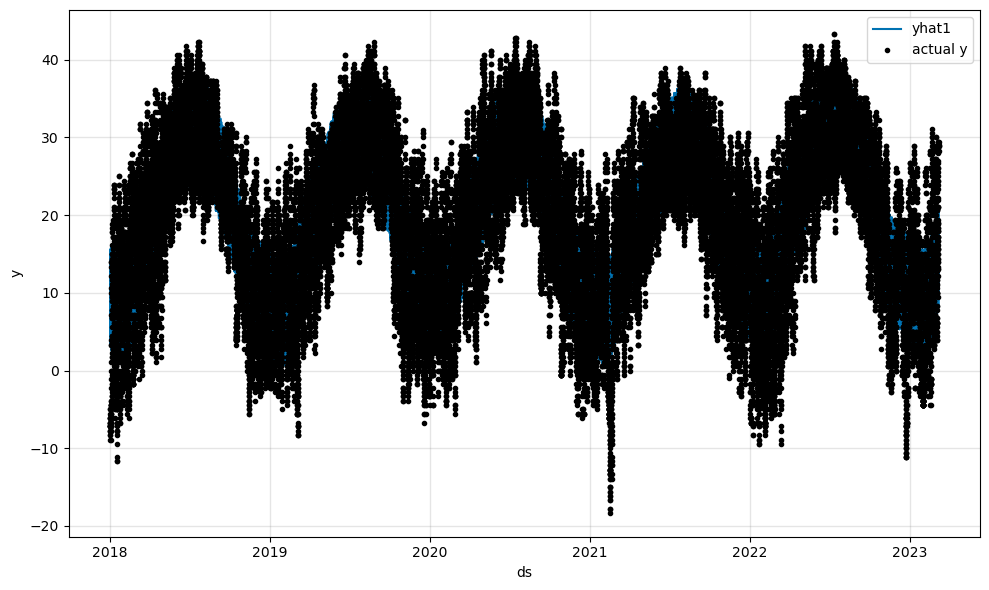

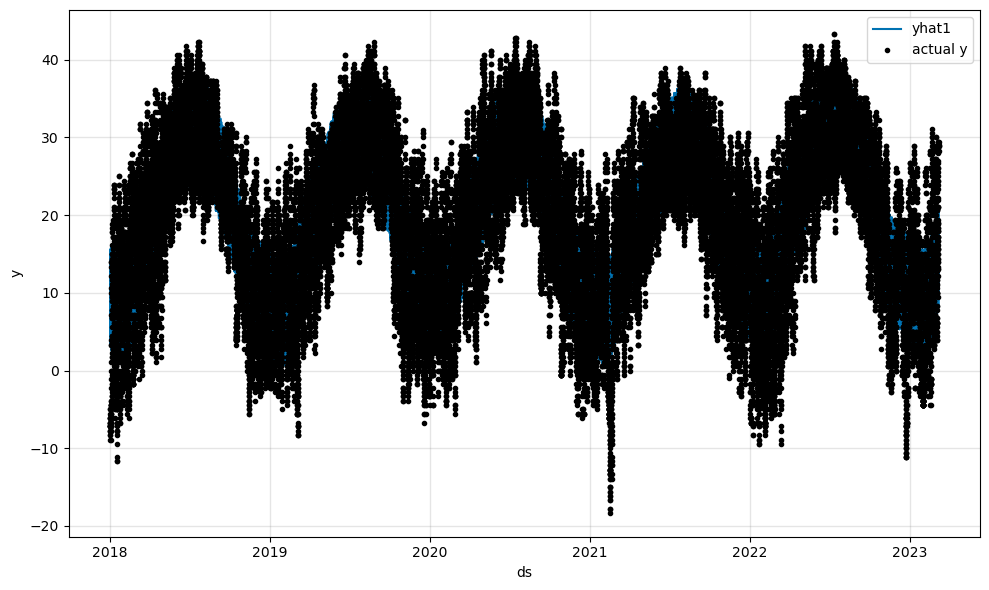

In [21]:
##This cell is the machine learning part, frequency is 'H' as this model uses hourly data. epochs is the number of times the machine runs the model
##The more epochs, the more accurate the model becomes, but it will be slower and there is will be a point where its unpractical to have a high epoch

from neuralprophet import NeuralProphet
m = NeuralProphet()
metrics = m.fit(df, freq='H', epochs=25)
forecast = m.predict(df)
m.plot(forecast) #This cell shows you the machines general prediction results. If bluelines are not in a reasonable line, you may need more epochs

In [25]:
##This cell focuses on getting a forecast, yhat is what the machine predicts, but other useful data comes out like daily, weekly, and seasonal
##daily differences. periods tells the machine how many hours to forecast for from the end of the dataset. The forecast is saved in csv.

future=m.make_future_dataframe(data, periods=120)
forecast=m.predict(future)
forecast.head()
forecast.to_csv('forecast_data')
forecast

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.998% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.167% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.167% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H


Predicting: 710it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


,ds,y,yhat1,trend,season_yearly,season_weekly,season_daily
0,2023-03-08 00:00:00,None,19.020832,20.262524,-6.230783,0.277850,4.711243
1,2023-03-08 01:00:00,None,16.867577,20.262497,-6.219510,0.287910,2.536681
2,2023-03-08 02:00:00,None,15.024815,20.262474,-6.208235,0.295866,0.674707
3,2023-03-08 03:00:00,None,13.773453,20.262447,-6.196959,0.301555,-0.593591
4,2023-03-08 04:00:00,None,12.809212,20.262428,-6.185684,0.304842,-1.572373
...,...,...,...,...,...,...,...
115,2023-03-12 19:00:00,None,21.158226,20.259769,-4.945724,0.430803,5.413377
116,2023-03-12 20:00:00,None,21.882786,20.259747,-4.934761,0.432780,6.125021
117,2023-03-12 21:00:00,None,22.319786,20.259720,-4.923804,0.432408,6.551461
118,2023-03-12 22:00:00,None,22.552650,20.259697,-4.912851,0.429688,6.776119
